# Liver tumors segmentation

Ahmed El Bajdali - ahmed.el-bajdali@student-cs.fr \
Marouane EL Ouarraq - marouane.el-ouarraq@student-cs.fr \
Cyrielle Théobald - cyrielle.theobald@student-cs.fr

## Initialization of the notebook 

### Useful Imports

In [1]:
import os
import csv

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import nibabel as nib
from tqdm import tqdm
import time 

from matplotlib.widgets import Slider
import ipywidgets as widgets
from ipywidgets import interact

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split

import nibabel as nib
import logging
nib_logger = logging.getLogger("nibabel")
nib_logger.setLevel(logging.ERROR)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class LiverSegmentationConfig:
    """Configuration class for liver tumor segmentation"""

    def __init__(self):
        self.train_dir = '/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6'
        self.labels_dir = '/kaggle/input/liver-tumor-segmentation/segmentations'

        self.volume_paths = list()
        self.seg_paths = list()

        # Parameters
        self.n_classes = 1
        self.window_size = (-20,120)
        self.batch_size = 8
        self.learning_rate = 1e-3

    def _init_paths(self):
        """Initialize volume and segmentation paths"""
        for file in os.listdir(self.train_dir):
            if file.endswith('.nii'):
                vol_path = os.path.join(self.train_dir, file)
                seg_file = file.replace('volume', 'segmentation')
                seg_path = os.path.join(self.labels_dir, seg_file)
                
                if os.path.exists(seg_path):
                    self.volume_paths.append(vol_path)
                    self.seg_paths.append(seg_path)
        
        print(f"Found {len(self.volume_paths)} volumes and {len(self.seg_paths)} segmentations")

In [4]:
config = LiverSegmentationConfig()
config._init_paths()

print(f"Example of a volume path: {config.volume_paths[4]}")
print(f"Example of a segmentation path: {config.seg_paths[4]}")

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '/kaggle/input/liver-tumor-segmentation-part-2/volume_pt6'

## Visualization 

In [5]:
index = 4

image_path = config.volume_paths[index]
data = nib.load(image_path).get_fdata().transpose(2,1,0)
segmentation = nib.load(config.seg_paths[index]).get_fdata().transpose(2,1,0)

def update(orientation):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data[orientation], cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(segmentation[orientation], cmap='gray')
    axes[1].set_title("Segmented Image") 
    plt.show()

interact(update, orientation = widgets.IntSlider(min=0, max=len(data)-1, step=1, value=len(data)//2));

interactive(children=(IntSlider(value=43, description='orientation', max=85), Output()), _dom_classes=('widget…

## Preprocessing and Data loading

In [6]:
def preprocessing(scan: np.ndarray, window: tuple = (-20,120)) -> np.ndarray:
    """Applying windowing for given Data and Normalizing"""
    min_value, max_value = window

    # scan = cv2.resize(scan,(256,256), interpolation = cv2.INTER_AREA)
    
    windowed_scan = np.clip(scan, min_value, max_value) # Windowing
    normalized_scan = ((windowed_scan - min_value) / (max_value - min_value)) # Normalization

    return normalized_scan

### Visualize preprocessing

In [8]:
index = 4

image_path = config.volume_paths[index]
data = nib.load(image_path).get_fdata().transpose(2,1,0)
segmentation = nib.load(config.seg_paths[index]).get_fdata().transpose(2,1,0)

def update_with_preprocessing(slice_id):
    raw_slice = data[slice_id]
    preprocessed = preprocessing(raw_slice)
    seg_slice = segmentation[slice_id]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(raw_slice, cmap='gray')
    axes[0].set_title("Original Slice")

    axes[1].imshow(preprocessed, cmap='gray')
    axes[1].set_title("Preprocessed")

    axes[2].imshow(seg_slice, cmap='gray')
    axes[2].set_title("Segmentation Mask")

    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

interact(update_with_preprocessing, slice_id = widgets.IntSlider(min=0, max=len(data)-1, step=1, value=len(data)//2));

interactive(children=(IntSlider(value=43, description='slice_id', max=85), Output()), _dom_classes=('widget-in…

## Unet

In [9]:
class SlicesDataset(Dataset):
    def __init__(self, volume_paths, seg_paths, transform=None):
        self.volume_paths = volume_paths
        self.seg_paths = seg_paths
        self.transform = transform
        self.slice_info = self._get_slice_info()

    def _get_slice_info(self):
        slice_info = []
        for vol_idx, volume_paths in enumerate(self.volume_paths):
            vol = nib.load(volume_paths)
            num_slices = vol.shape[2]
            for slice_idx in range(num_slices):
                slice_info.append((vol_idx, slice_idx))
        return slice_info

    def __len__(self):
        return len(self.slice_info)

    def __getitem__(self, idx):
        
        vol_idx, slice_idx = self.slice_info[idx]
        
        vol = nib.load(self.volume_paths[vol_idx]).get_fdata()
        seg = nib.load(self.seg_paths[vol_idx]).get_fdata()
        
        # if self.transform:
        #     vol = self.transform(vol)

        slice_vol = vol[:, :, slice_idx]
        slice_seg = seg[:, :, slice_idx]
        
        X = cv2.resize(slice_vol, (256, 256), interpolation=cv2.INTER_AREA)
        Y = cv2.resize(slice_seg, (256, 256), interpolation=cv2.INTER_AREA)
        
        X = np.expand_dims(X, axis=0)
        Y = np.expand_dims(Y, axis=0)

        # Y = cv2.resize(seg[:,:,slice_idx],(256,256),interpolation=cv2.INTER_AREA)
        # X = np.expand_dims(vol[:, :, slice_idx], axis=0)
        # Y = np.expand_dims(Y, axis=0)
        if self.transform:
            X = self.transform(X)
                    
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(config.volume_paths, config.seg_paths, test_size = 0.2, random_state = 0)

In [11]:
train_dataset = SlicesDataset(X_train, Y_train, transform = preprocessing)
test_dataset = SlicesDataset(X_test, Y_test, transform = preprocessing)

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = config.batch_size, shuffle = True)

## Training

In [13]:
class UNet(nn.Module):
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def __init__(self):
        super().__init__()

        # Encoder path
        self.enc1 = self.conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, config.n_classes, kernel_size=1)
        
    def forward(self, x):
        
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        x4 = self.enc4(self.pool3(x3))

        # Bottleneck
        x = self.bottleneck(self.pool4(x4))

        # Decoder
        x = self.upconv4(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec4(x)

        x = self.upconv3(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3(x)

        x = self.upconv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)

        x = self.upconv1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)

        return self.final_conv(x)

### Metrics

In [14]:
def dice_loss(outputs, targets):
    intersection = torch.sum(outputs * targets)
    union = torch.sum(outputs) + torch.sum(targets)
    dice_score = (2. * intersection) / (union + 1e-6).mean()
    return 1 - dice_score 
    
def compute_metrics(outputs, targets, epsilon=1e-8):
    """
    Computes Dice score, Dice loss, IoU, Precision, and Recall.
    
    Args:
        outputs (torch.Tensor): Predicted mask (probabilistic).
        target (torch.Tensor): Ground truth mask.
        epsilon (float): Small value to avoid division by zero.
    
    Returns:
        dict: A dictionary containing all computed metrics.
    """
    classification = (outputs > 0.5).float()
    targets = targets.float()
    
    # Dice Score
    intersection = torch.sum(classification * targets, dim=(1,2,3))
    union = torch.sum(classification, dim=(1,2,3)) + torch.sum(targets, dim=(1,2,3))
    dice = ((2. * intersection + epsilon) / (union + epsilon)).mean()

    # Dice Loss
    loss = 1 - dice

    # IoU
    iou_inter = (classification * targets).sum()
    iou_union = classification.sum() + targets.sum() - iou_inter
    iou = (iou_inter / (iou_union)).item() if iou_union > 0 else 1.0

    # Precision
    tp = (classification * targets).sum()
    fp = (classification * (1 - targets)).sum()
    precision = (tp / (tp + fp + epsilon))

    # Recall
    fn = ((1 - classification) * targets).sum()
    recall = (tp / (tp + fn + epsilon))

    return {
        "dice_score": dice.item(),
        "dice_loss": loss.item(),
        "iou_score": iou,
        "precision": precision.item(),
        "recall": recall.item()
    }

In [15]:
def validation_metrics(model, dataloader):
    val_loss = 0.0
    val_dice = 0.0
    val_iou = 0.0
    val_recall = 0.0
    val_precision = 0.0

    model.eval()
    
    val_iterator = tqdm(dataloader, desc=f"Validation...", leave = False)
    with torch.no_grad():
        for inputs, segmentation_masks in val_iterator:
            inputs = inputs.to(device)
            segmentation_masks = segmentation_masks.to(device)
            
            outputs = model(inputs)
            outputs = (torch.sigmoid(outputs))

            loss = criterion(outputs, segmentation_masks)
            
            metrics = compute_metrics(outputs, segmentation_masks)
            
            val_loss += metrics['dice_loss']
            val_dice += metrics['dice_score']
            val_iou += metrics['iou_score']
            val_recall += metrics['recall']
            val_precision += metrics['precision']

    return (val_loss/ len(dataloader)),(val_dice/ len(dataloader)), (val_iou/ len(dataloader)), (val_recall/ len(dataloader)),(val_precision/ len(dataloader))

def log_metrics_to_csv(epoch, epoch_time, train_metrics, val_metrics):
    with open(log_file, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=log_fields)
        writer.writerow({
            "epoch": epoch,
            "time": epoch_time,
            "train_loss": train_metrics['loss'],
            "val_loss": val_metrics['loss'],
            "dice_train": train_metrics['dice'],
            "dice_val": val_metrics['dice'],
            "mIou_train": train_metrics['iou'],
            "mIou_val": val_metrics['iou'],
            "precision_train": train_metrics['precision'],
            "precision_val": val_metrics['precision'],
            "recall_train": train_metrics['recall'],
            "recall_val": val_metrics['recall']
        })

In [16]:
model = UNet().to(device)
print(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc4): Sequential(
    (0): Con

In [17]:
criterion = dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
num_epochs = 5

log_file = "UNet.csv"  
log_fields = ["epoch", "time", 
              "train_loss", "val_loss", 
              "dice_train", "dice_val", 
              "mIou_train", "mIou_val", 
              "precision_train", "precision_val", 
              "recall_train", "recall_val",]

In [19]:
def visualize_prediction(model, index, orientation=63):
    model.eval()
    with torch.no_grad():
        try:
            # Load volume and mask
            image_path = config.volume_paths[index]
            mask_path = config.seg_paths[index]
            data = nib.load(image_path).get_fdata().transpose(2, 1, 0)
            mask = nib.load(mask_path).get_fdata().transpose(2, 1, 0)

            # Select slice
            image_slice = data[orientation]
            image_slice = preprocessing(image_slice)
            mask_slice = mask[orientation]

            # Preprocess (resize, normalize, convert to tensor)
            image_tensor = torch.tensor(image_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
            # image_tensor = F.interpolate(image_tensor, size=(256, 256), mode='bilinear')  # 
            image_tensor = image_tensor.to(device)

            # Prediction
            output = torch.sigmoid(model(image_tensor))
            pred_mask = (output > 0.5).float().squeeze().cpu().numpy()

            # Resize mask_slice to match prediction for fair display
            mask_tensor = torch.tensor(mask_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            mask_tensor = F.interpolate(mask_tensor, size=(256, 256), mode='nearest')
            mask_resized = mask_tensor.squeeze().numpy()

            # Plot
            fig, axes = plt.subplots(1, 3, figsize=(10, 6))
            axes[0].imshow(image_tensor.squeeze().cpu(), cmap='gray')
            axes[0].set_title("Input Image")
            axes[1].imshow(mask_resized, cmap='gray')
            axes[1].set_title("Ground Truth")
            axes[2].imshow(pred_mask, cmap='gray')
            axes[2].set_title("Prediction")
            for ax in axes:
                ax.axis('off')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Could not load or process image: {e}")

def init_training(model, optimizer, log_file, log_fields, checkpoint_path):
    best_dice = 0
    start_epoch = 0

    if not os.path.exists(log_file):
        with open(log_file, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=log_fields)
            writer.writeheader()

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_dice = checkpoint.get('best_dice', 0)
        print(f"Resuming from epoch {start_epoch} with best Dice {best_dice:.4f}")
    else:
        print("Starting training from scratch.")

    return start_epoch, best_dice


def run_one_epoch(model, optimizer, criterion, train_dataloader, test_dataloader,
                  epoch, best_dice, save_path, checkpoint_path, log_file, log_fields):
    
    model.train()
    epoch_start_time = time.time()

    train_iterator = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}")
    running_metrics = {'loss': 0.0, 'dice': 0.0, 'iou': 0.0, 'precision': 0.0, 'recall': 0.0}

    for i, (inputs, masks) in train_iterator:
        inputs, masks = inputs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = torch.sigmoid(model(inputs))
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        metrics = compute_metrics(outputs, masks)

        running_metrics['loss'] += metrics['dice_loss']
        running_metrics['dice'] += metrics['dice_score']
        running_metrics['iou'] += metrics['iou_score']
        running_metrics['precision'] += metrics['precision']
        running_metrics['recall'] += metrics['recall']

        avg_metrics = {k: v / (i + 1) for k, v in running_metrics.items()}
        train_iterator.set_postfix({
            'loss': f"{avg_metrics['loss']:.4f}",
            'dice': f"{avg_metrics['dice']:.4f}",
            'miou': f"{avg_metrics['iou']:.4f}",
            'precision': f"{avg_metrics['precision']:.4f}",
            'recall': f"{avg_metrics['recall']:.4f}"
        })

    # Validation
    val_loss, val_dice, val_iou, val_recall, val_precision = validation_metrics(model, test_dataloader)
    val_metrics = {
        'loss': val_loss,
        'dice': val_dice,
        'iou': val_iou,
        'precision': val_precision,
        'recall': val_recall
    }

    # Save best model
    if val_dice > best_dice:
        torch.save(model.state_dict(), save_path)
        best_dice = val_dice
        print(f"Epoch {epoch+1}: New best model saved with Dice {val_dice:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_dice': best_dice
    }, checkpoint_path)

    # Log
    epoch_time = time.time() - epoch_start_time
    log_metrics_to_csv(epoch, epoch_time, avg_metrics, val_metrics)

    return best_dice

Starting training from scratch.


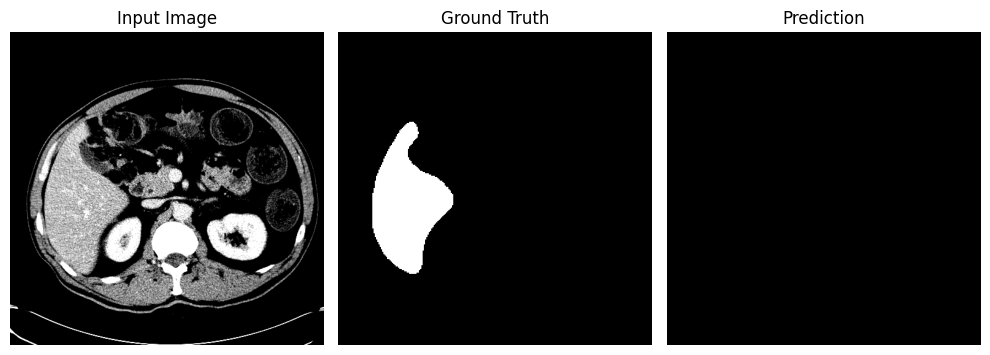

In [20]:
start_epoch, best_dice = init_training(model, optimizer, log_file, log_fields, checkpoint_path="last_checkpoint.pt")
current_epoch = start_epoch
visualize_prediction(model, 4, 63)


=== Epoch 1 ===


Epoch 1: 100%|██████████| 1885/1885 [2:48:49<00:00,  5.37s/it, loss=0.3378, dice=0.6622, miou=0.0428, precision=0.0003, recall=0.0032]  


Epoch 1: New best model saved with Dice 0.6936


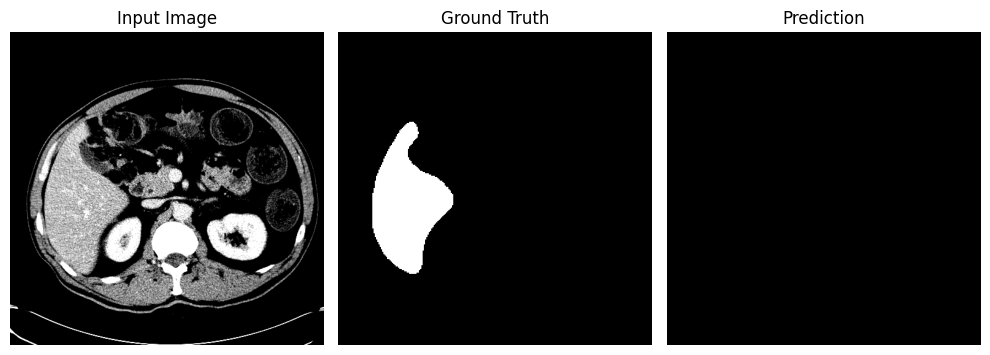

In [21]:
print(f"\n=== Epoch {current_epoch+1} ===")

best_dice = run_one_epoch(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epoch=current_epoch,
    best_dice=best_dice,
    save_path="/kaggle/working/best_model.pt",
    checkpoint_path="/kaggle/working/last_checkpoint.pt",
    log_file=log_file,
    log_fields=log_fields
)
current_epoch += 1
visualize_prediction(model, 4, 63)

In [ ]:
print(f"\n=== Epoch {current_epoch+1} ===")

best_dice = run_one_epoch(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epoch=current_epoch,
    best_dice=best_dice,
    save_path="/kaggle/working/best_model.pt",
    checkpoint_path="/kaggle/working/last_checkpoint.pt",
    log_file=log_file,
    log_fields=log_fields
)
current_epoch += 1
visualize_prediction(model, 4, 63)


=== Epoch 2 ===


Epoch 2:  65%|██████▌   | 1227/1885 [1:50:14<58:11,  5.31s/it, loss=0.3341, dice=0.6659, miou=0.0342, precision=0.0000, recall=0.0000]  

Display Training

In [ ]:
df = pd.read_csv(log_file)
display(df)

plt.figure(figsize=(15, 10))

# Loss 
plt.subplot(2, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Dice score 
plt.subplot(2, 2, 2)
plt.plot(df['epoch'], df['dice_train'], label='Train Dice')
plt.plot(df['epoch'], df['dice_val'], label='Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Dice Score Evolution')
plt.legend()

# IoU 
plt.subplot(2, 2, 3)
plt.plot(df['epoch'], df['mIou_train'], label='Train IoU')
plt.plot(df['epoch'], df['mIou_val'], label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.title('IoU Score Evolution')
plt.legend()

# Precision-Recall 
plt.subplot(2, 2, 4)
plt.plot(df['epoch'], df['precision_train'], label='Train Precision')
plt.plot(df['epoch'], df['precision_val'], label='Validation Precision')
plt.plot(df['epoch'], df['recall_train'], label='Train Recall')
plt.plot(df['epoch'], df['recall_val'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision and Recall Evolution')
plt.legend()

plt.tight_layout()
plt.show()